## Actor-Critic implementation for FrozenLake

In [1]:
import sys

sys.path.append("../src")

%load_ext autoreload
%autoreload 2

In [2]:
import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)

print(f"Using device: {device}")

Using device: mps


In [3]:
# Import necessary libraries

import random
import time
from collections import deque
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.autograd import Variable
from torch.distributions import Categorical

from itertools import count
import seaborn as sns
import shutil

import matplotlib.pyplot as plt

import cv2
import imageio

from utils import create_env, show
from base_agent import BaseAgent
from replay_memory import ReplayMemory, Transition
from summary_writer import LocalSummaryWriter
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [4]:
class ActorNetwork(nn.Module):
    """Actor Network for the policy gradient method."""

    def __init__(self, state_size, action_size):
        super(ActorNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, self.action_size)

    def forward(self, state):
        """Forward pass through the network."""
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        distribution = Categorical(F.softmax(output, dim=-1))
        return distribution


In [5]:
class CriticNetwork(nn.Module):
    """Critic Network for Policy Gradient."""

    # The critic network is used to estimate the value function.
    def __init__(self, state_size, action_size):
        super(CriticNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, state):
        """Forward pass through the network."""
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

In [39]:
"""Actor and Critic Networks for the A2C algorithm."""


class A2CAgent(BaseAgent):
    """Agent class for the Actor-Critic algorithm."""

    def __init__(
        self,
        env: gym.Env,
        gamma=0.99,
        lr=5e-4,
        buffer_size=int(1e5),
        batch_size=100,
        learn_every=4,
        writer=None,
        seed=42,
    ):
        super(A2CAgent, self).__init__(env=env)
        self.action_size = self.env.action_space.n
        self.state_size = self.env.observation_space.n
        self.learn_every = learn_every
        self.batch_size = batch_size
        self.gamma = gamma
        self.actor = ActorNetwork(self.state_size, self.action_size).to(device)
        self.critic = CriticNetwork(self.state_size, self.action_size).to(device)
        self.optimizerA = optim.Adam(self.actor.parameters(), lr=lr)
        self.optimizerC = optim.Adam(self.critic.parameters(), lr=lr)
        self.memory = ReplayMemory(buffer_size)
        self.learn_step = 0
        self.writer = writer
        self.plots = {"Loss": [], "Epsilon": [], "Reward": [], "Mean Reward": []}
        self.seed = seed

    def compute_returns(self, next_value, rewards, masks, gamma=0.99):
        """Compute the returns for the given rewards and masks."""
        R = next_value
        returns = []
        for step in reversed(range(len(rewards))):
            R = rewards[step] + gamma * R * masks[step]
            returns.insert(0, R)
        return returns

    def act(self, state):
        """Select an action based on the current state."""
        logits = self.actor(state)
        dist = Categorical(logits=logits)
        action = dist.sample()

        return action.item(), dist.log_prob(action)

    def step(self, action: int) -> tuple[int, any, Tensor, bool, bool]:
        """Take a step in the environment."""
        state, reward, done, terminated, _ = self.env.step(action)
        return (
            state,
            reward,
            done,
            terminated,
        )

    def optimize(self):
        """Sample a batch of experiences and update the actor and critic networks."""
        pass

    def state_preprocess(self, state: int, num_states: int):
        if self.env.spec.id in ["FrozenLake-v1"]:
            onehot_vector = torch.zeros(num_states, dtype=torch.float32, device=device)
            onehot_vector[state] = 1
            return onehot_vector
        else:
            return torch.as_tensor(state, dtype=torch.float32, device=device)
        
    # Training loop
    def train(self, num_episodes=500, smooth=100):
        """Train the agent."""
        smoothed_reward = []
        raw_reward = []
        elapsed_times = []
        mean_reward = 0
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            state = torch.FloatTensor(state).to(device)

            log_probs = []
            values = []
            rewards = []
            masks = []
            entropy = 0
            total_reward = 0
            start_time = time.time()

            for i in count():
                state = self.state_preprocess(state.int(), self.state_size)

                dist, q_value = self.actor(state), self.critic(state)

                action = dist.sample()
                next_state, reward, done, terminate, _ = self.env.step(action.item())
                next_state = self.state_preprocess(next_state, self.state_size)
                done = done or terminate

                log_prob = dist.log_prob(action).unsqueeze(0)
                entropy += dist.entropy().mean()

                log_probs.append(log_prob)
                values.append(q_value)
                rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
                masks.append(torch.tensor([1 - done], dtype=torch.float, device=device))
                total_reward += reward
                state = next_state
                end_time = time.time()
                if done or terminate:
                    elapsed_time = end_time - start_time
                    # print("Iteration: {}, Score: {}".format(episode, i))
                    break

            next_value = self.critic(next_state)
            returns = self.compute_returns(next_value, rewards, masks, self.gamma)

            log_probs = torch.cat(log_probs)
            returns = torch.cat(returns).detach()
            values = torch.cat(values)

            advantage = returns - values

            actor_loss = -(log_probs * advantage.detach()).mean()
            critic_loss = advantage.pow(2).mean()

            self.optimizerA.zero_grad()
            self.optimizerC.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.optimizerA.step()
            self.optimizerC.step()

            elapsed_times.append(elapsed_time)
            raw_reward.append(total_reward)
            smoothed_reward.append(total_reward)
            if len(smoothed_reward) > smooth:
                smoothed_reward = smoothed_reward[-1 * smooth : -1]

            mean_reward = np.mean(smoothed_reward)

            self.writer.add_scalar("Reward", total_reward, episode)
            self.writer.add_scalar("Mean Reward", np.mean(smoothed_reward), episode)

            self.plots["Reward"].append(total_reward)
            self.plots["Mean Reward"].append(mean_reward)

            if episode % 100 == 0:
                print(
                    "\tEpisode {} \t Latest Reward {:.2f} \t Average Reward: {:.2f}".format(
                        episode, total_reward, np.mean(smoothed_reward)
                    )
                )

        print(
            "\tEpisode {} \t Final Reward {:.2f} \t Average Reward: {:.2f}".format(
                num_episodes, total_reward, np.mean(smoothed_reward)
            )
        )
        return elapsed_times, raw_reward, smoothed_reward

    def run(self, episodes=100):
        """Run/test the agent in the environment."""
        self.load()

        state, _ = self.env.reset(seed=self.seed)
        done = False
        truncation = False
        step_size = 0
        episode_reward = 0
        frames = []

        frame = self.env.render()
        frames.append(frame)
        while not done and not truncation:
            state = self.state_preprocess(state, num_states=self.state_size)
            dist = self.actor(state)
            action = dist.sample()
            next_state, reward, done, truncation, _ = self.env.step(action.item())

            state = next_state
            episode_reward += reward
            step_size += 1

            frame = self.env.render()
            frames.append(frame)

        # Print log
        result = f"Steps: {step_size:}, Reward: {episode_reward:.2f}, "
        print(result)

        print("\tSaving Animation ...")

        video_path = "%s/%s-movie.mp4" % (self.writer.log_dir, self.env.spec.id)
        fps = 30
        imageio.mimsave(video_path, frames, fps=fps)

        video = cv2.VideoCapture(video_path)

        frame_per_second = video.get(cv2.CAP_PROP_FPS)
        assert frame_per_second == fps, f"FPS should be {fps} but got {frame_per_second}"
        frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)

        return frame_count / frame_per_second if frame_per_second > 0 else 0, episode_reward

    def plot(self):
        """Plot the training results."""
        sns.set()
        sns.set_context("poster")

        plt.figure(figsize=(20, 16))
        plt.plot(np.arange(len(self.plots["Reward"])), self.plots["Reward"], label="Reward")
        plt.plot(
            np.arange(len(self.plots["Mean Reward"])),
            self.plots["Mean Reward"],
            label="Mean Reward",
        )
        plt.legend()
        plt.title("ACM Gradient Rewards")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.savefig("%s/plot_%s.png" % (self.writer.log_dir, "rewards"))

    def save(self):
        """Save the model."""
        torch.save(self.actor.state_dict(), "%s/model.pt" % self.writer.log_dir)

    def load(self):
        """Load the model."""
        self.actor.load_state_dict(torch.load("%s/model.pt" % self.writer.log_dir))
        self.actor.eval()

In [38]:
def main(RL_hyperparams):
    """Train and Run the DQN agent."""
    torch.manual_seed(RL_hyperparams["random_seed"])
    np.random.seed(RL_hyperparams["random_seed"])
    random.seed(RL_hyperparams["random_seed"])

    rewards = []
    run_times = []
    for i in range(1, RL_hyperparams["number_of_experiments"] + 1):
        print("[Experiment]\t{} of {}".format(i, RL_hyperparams["number_of_experiments"]))

        if i == 1:
            path = f"../experiments/a2c_frozenlake/run-{i}"
            shutil.rmtree(path, ignore_errors=True)

            writer = LocalSummaryWriter(path)
            writer.add_parameters(RL_hyperparams)

            print("[Env]\tCreating Environment ...")
            random_map = generate_random_map(size=8, p=0.9)
            env = gym.make(
                "FrozenLake-v1",
                desc=random_map,
                render_mode="rgb_array",
                is_slippery=False,
            )

            action_space = env.action_space
            action_space.seed(
                RL_hyperparams["random_seed"]
            )  # Set the seed to get reproducible results when sampling the action space
            env.reset()

            runner = A2CAgent(
                env,
                seed=RL_hyperparams["random_seed"],
                batch_size=RL_hyperparams["batch_size"],
                lr=RL_hyperparams["lr"],
                gamma=RL_hyperparams["gamma"],
                learn_every=RL_hyperparams["learn_every"],
                writer=writer,
            )

            print("[Train]\tTraining Beginning ...")
            train_times, train_rewards, _ = runner.train(RL_hyperparams["num_episodes"])

            print("[Plot]\tPlotting Training Curves ...")
            runner.plot()

            print("[Save]\tSaving Model ...")
            runner.save()

        print("[Run]\tRunning Simulation ...")
        run_time, reward = runner.run()
        rewards.append(reward)
        run_times.append(run_time)

        print("[Video]\tShow Video ...")
        video_path = "%s/%s-movie.mp4" % (writer.log_dir, env.spec.id)
        show(video_path)

    print("[End]\tDone. Congratulations!")

    print("[Reward]\tAverage Reward: ", np.mean(rewards))
    print("[Reward]\tStandard Deviation of Reward: ", np.std(rewards))
    print("[Reward]\tMax Reward: ", np.max(rewards))
    print("[Reward]\tMin Reward: ", np.min(rewards))

    print("[RunTime]\tAverage Run Time: ", np.mean(run_times))
    print("[RunTime]\tStandard Deviation of Run Time: ", np.std(run_times))
    print("[RunTime]\tMax Run Time: ", np.max(run_times))
    print("[RunTime]\tMin Run Time: ", np.min(run_times))

    print("[TrainingTime]\tAverage Training Time: ", np.mean(train_times))
    print("[TrainingTime]\tMax Training Time: ", np.max(train_times))
    print("[TrainingTime]\tMin Training Time: ", np.min(train_times))

    print("[TrainingReward]\tAverage Training Reward: ", np.mean(train_rewards))
    print("[TrainingReward]\tMax Training Rewards: ", np.max(train_rewards))
    print("[TrainingReward]\tMin Training Rewards: ", np.min(train_rewards))

[Experiment]	1 of 50
[Env]	Creating Environment ...
[Train]	Training Beginning ...
	Episode 0 	 Latest Reward 0.00 	 Average Reward: 0.00
	Episode 100 	 Latest Reward 0.00 	 Average Reward: 0.04
	Episode 200 	 Latest Reward 0.00 	 Average Reward: 0.03
	Episode 300 	 Latest Reward 0.00 	 Average Reward: 0.01
	Episode 400 	 Latest Reward 0.00 	 Average Reward: 0.02
	Episode 500 	 Latest Reward 0.00 	 Average Reward: 0.02
	Episode 600 	 Latest Reward 0.00 	 Average Reward: 0.02
	Episode 700 	 Latest Reward 0.00 	 Average Reward: 0.02
	Episode 800 	 Latest Reward 0.00 	 Average Reward: 0.01
	Episode 900 	 Latest Reward 0.00 	 Average Reward: 0.03
	Episode 1000 	 Latest Reward 0.00 	 Average Reward: 0.04
	Episode 1100 	 Latest Reward 0.00 	 Average Reward: 0.07
	Episode 1200 	 Latest Reward 1.00 	 Average Reward: 0.12
	Episode 1300 	 Latest Reward 0.00 	 Average Reward: 0.09
	Episode 1400 	 Latest Reward 0.00 	 Average Reward: 0.14
	Episode 1500 	 Latest Reward 0.00 	 Average Reward: 0.28
	

frame per second=30.0
frame count=53.0
duration=1.7666666666666666
[Experiment]	2 of 50
[Run]	Running Simulation ...
Steps: 40, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=41.0
duration=1.3666666666666667
[Experiment]	3 of 50
[Run]	Running Simulation ...
Steps: 43, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=44.0
duration=1.4666666666666666
[Experiment]	4 of 50
[Run]	Running Simulation ...
Steps: 10, Reward: 0.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=11.0
duration=0.36666666666666664
[Experiment]	5 of 50
[Run]	Running Simulation ...
Steps: 26, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=27.0
duration=0.9
[Experiment]	6 of 50
[Run]	Running Simulation ...
Steps: 55, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=56.0
duration=1.8666666666666667
[Experiment]	7 of 50
[Run]	Running Simulation ...
Steps: 45, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=46.0
duration=1.5333333333333334
[Experiment]	8 of 50
[Run]	Running Simulation ...
Steps: 52, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=53.0
duration=1.7666666666666666
[Experiment]	9 of 50
[Run]	Running Simulation ...
Steps: 36, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=37.0
duration=1.2333333333333334
[Experiment]	10 of 50
[Run]	Running Simulation ...
Steps: 21, Reward: 0.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=22.0
duration=0.7333333333333333
[Experiment]	11 of 50
[Run]	Running Simulation ...
Steps: 47, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=48.0
duration=1.6
[Experiment]	12 of 50
[Run]	Running Simulation ...
Steps: 30, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=31.0
duration=1.0333333333333334
[Experiment]	13 of 50
[Run]	Running Simulation ...
Steps: 32, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=33.0
duration=1.1
[Experiment]	14 of 50
[Run]	Running Simulation ...
Steps: 47, Reward: 0.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=48.0
duration=1.6
[Experiment]	15 of 50
[Run]	Running Simulation ...
Steps: 10, Reward: 0.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=11.0
duration=0.36666666666666664
[Experiment]	16 of 50
[Run]	Running Simulation ...
Steps: 43, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=44.0
duration=1.4666666666666666
[Experiment]	17 of 50
[Run]	Running Simulation ...
Steps: 78, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=79.0
duration=2.6333333333333333
[Experiment]	18 of 50
[Run]	Running Simulation ...
Steps: 23, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=24.0
duration=0.8
[Experiment]	19 of 50
[Run]	Running Simulation ...
Steps: 35, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=36.0
duration=1.2
[Experiment]	20 of 50
[Run]	Running Simulation ...
Steps: 50, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=51.0
duration=1.7
[Experiment]	21 of 50
[Run]	Running Simulation ...
Steps: 34, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=35.0
duration=1.1666666666666667
[Experiment]	22 of 50
[Run]	Running Simulation ...
Steps: 10, Reward: 0.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=11.0
duration=0.36666666666666664
[Experiment]	23 of 50
[Run]	Running Simulation ...
Steps: 33, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=34.0
duration=1.1333333333333333
[Experiment]	24 of 50
[Run]	Running Simulation ...
Steps: 10, Reward: 0.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=11.0
duration=0.36666666666666664
[Experiment]	25 of 50
[Run]	Running Simulation ...
Steps: 33, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=34.0
duration=1.1333333333333333
[Experiment]	26 of 50
[Run]	Running Simulation ...
Steps: 38, Reward: 0.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=39.0
duration=1.3
[Experiment]	27 of 50
[Run]	Running Simulation ...
Steps: 38, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=39.0
duration=1.3
[Experiment]	28 of 50
[Run]	Running Simulation ...
Steps: 29, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=30.0
duration=1.0
[Experiment]	29 of 50
[Run]	Running Simulation ...
Steps: 19, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=20.0
duration=0.6666666666666666
[Experiment]	30 of 50
[Run]	Running Simulation ...
Steps: 9, Reward: 0.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=10.0
duration=0.3333333333333333
[Experiment]	31 of 50
[Run]	Running Simulation ...
Steps: 82, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=83.0
duration=2.7666666666666666
[Experiment]	32 of 50
[Run]	Running Simulation ...
Steps: 32, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=33.0
duration=1.1
[Experiment]	33 of 50
[Run]	Running Simulation ...
Steps: 61, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=62.0
duration=2.066666666666667
[Experiment]	34 of 50
[Run]	Running Simulation ...
Steps: 43, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=44.0
duration=1.4666666666666666
[Experiment]	35 of 50
[Run]	Running Simulation ...
Steps: 10, Reward: 0.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=11.0
duration=0.36666666666666664
[Experiment]	36 of 50
[Run]	Running Simulation ...
Steps: 30, Reward: 0.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=31.0
duration=1.0333333333333334
[Experiment]	37 of 50
[Run]	Running Simulation ...
Steps: 37, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=38.0
duration=1.2666666666666666
[Experiment]	38 of 50
[Run]	Running Simulation ...
Steps: 10, Reward: 0.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=11.0
duration=0.36666666666666664
[Experiment]	39 of 50
[Run]	Running Simulation ...
Steps: 46, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=47.0
duration=1.5666666666666667
[Experiment]	40 of 50
[Run]	Running Simulation ...
Steps: 43, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=44.0
duration=1.4666666666666666
[Experiment]	41 of 50
[Run]	Running Simulation ...
Steps: 28, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=29.0
duration=0.9666666666666667
[Experiment]	42 of 50
[Run]	Running Simulation ...
Steps: 51, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=52.0
duration=1.7333333333333334
[Experiment]	43 of 50
[Run]	Running Simulation ...
Steps: 22, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=23.0
duration=0.7666666666666667
[Experiment]	44 of 50
[Run]	Running Simulation ...
Steps: 56, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=57.0
duration=1.9
[Experiment]	45 of 50
[Run]	Running Simulation ...
Steps: 36, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=37.0
duration=1.2333333333333334
[Experiment]	46 of 50
[Run]	Running Simulation ...
Steps: 10, Reward: 0.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=11.0
duration=0.36666666666666664
[Experiment]	47 of 50
[Run]	Running Simulation ...
Steps: 31, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=32.0
duration=1.0666666666666667
[Experiment]	48 of 50
[Run]	Running Simulation ...
Steps: 27, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=28.0
duration=0.9333333333333333
[Experiment]	49 of 50
[Run]	Running Simulation ...
Steps: 57, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=58.0
duration=1.9333333333333333
[Experiment]	50 of 50
[Run]	Running Simulation ...
Steps: 41, Reward: 1.00, 
	Saving Animation ...
[Video]	Show Video ...


frame per second=30.0
frame count=42.0
duration=1.4
[End]	Done. Congratulations!
[Reward]	Average Reward:  0.76
[Reward]	Standard Deviation of Reward:  0.4270831300812525
[Reward]	Max Reward:  1.0
[Reward]	Min Reward:  0.0
[RunTime]	Average Run Time:  1.2206666666666666
[RunTime]	Standard Deviation of Run Time:  0.5595192380765631
[RunTime]	Max Run Time:  2.7666666666666666
[RunTime]	Min Run Time:  0.3333333333333333
[TrainingTime]	Average Training Time:  0.20997758209705353
[TrainingTime]	Max Training Time:  0.44655680656433105
[TrainingTime]	Min Training Time:  0.013588190078735352
[TrainingReward]	Average Training Reward:  0.538
[TrainingReward]	Max Training Rewards:  1.0
[TrainingReward]	Min Training Rewards:  0.0


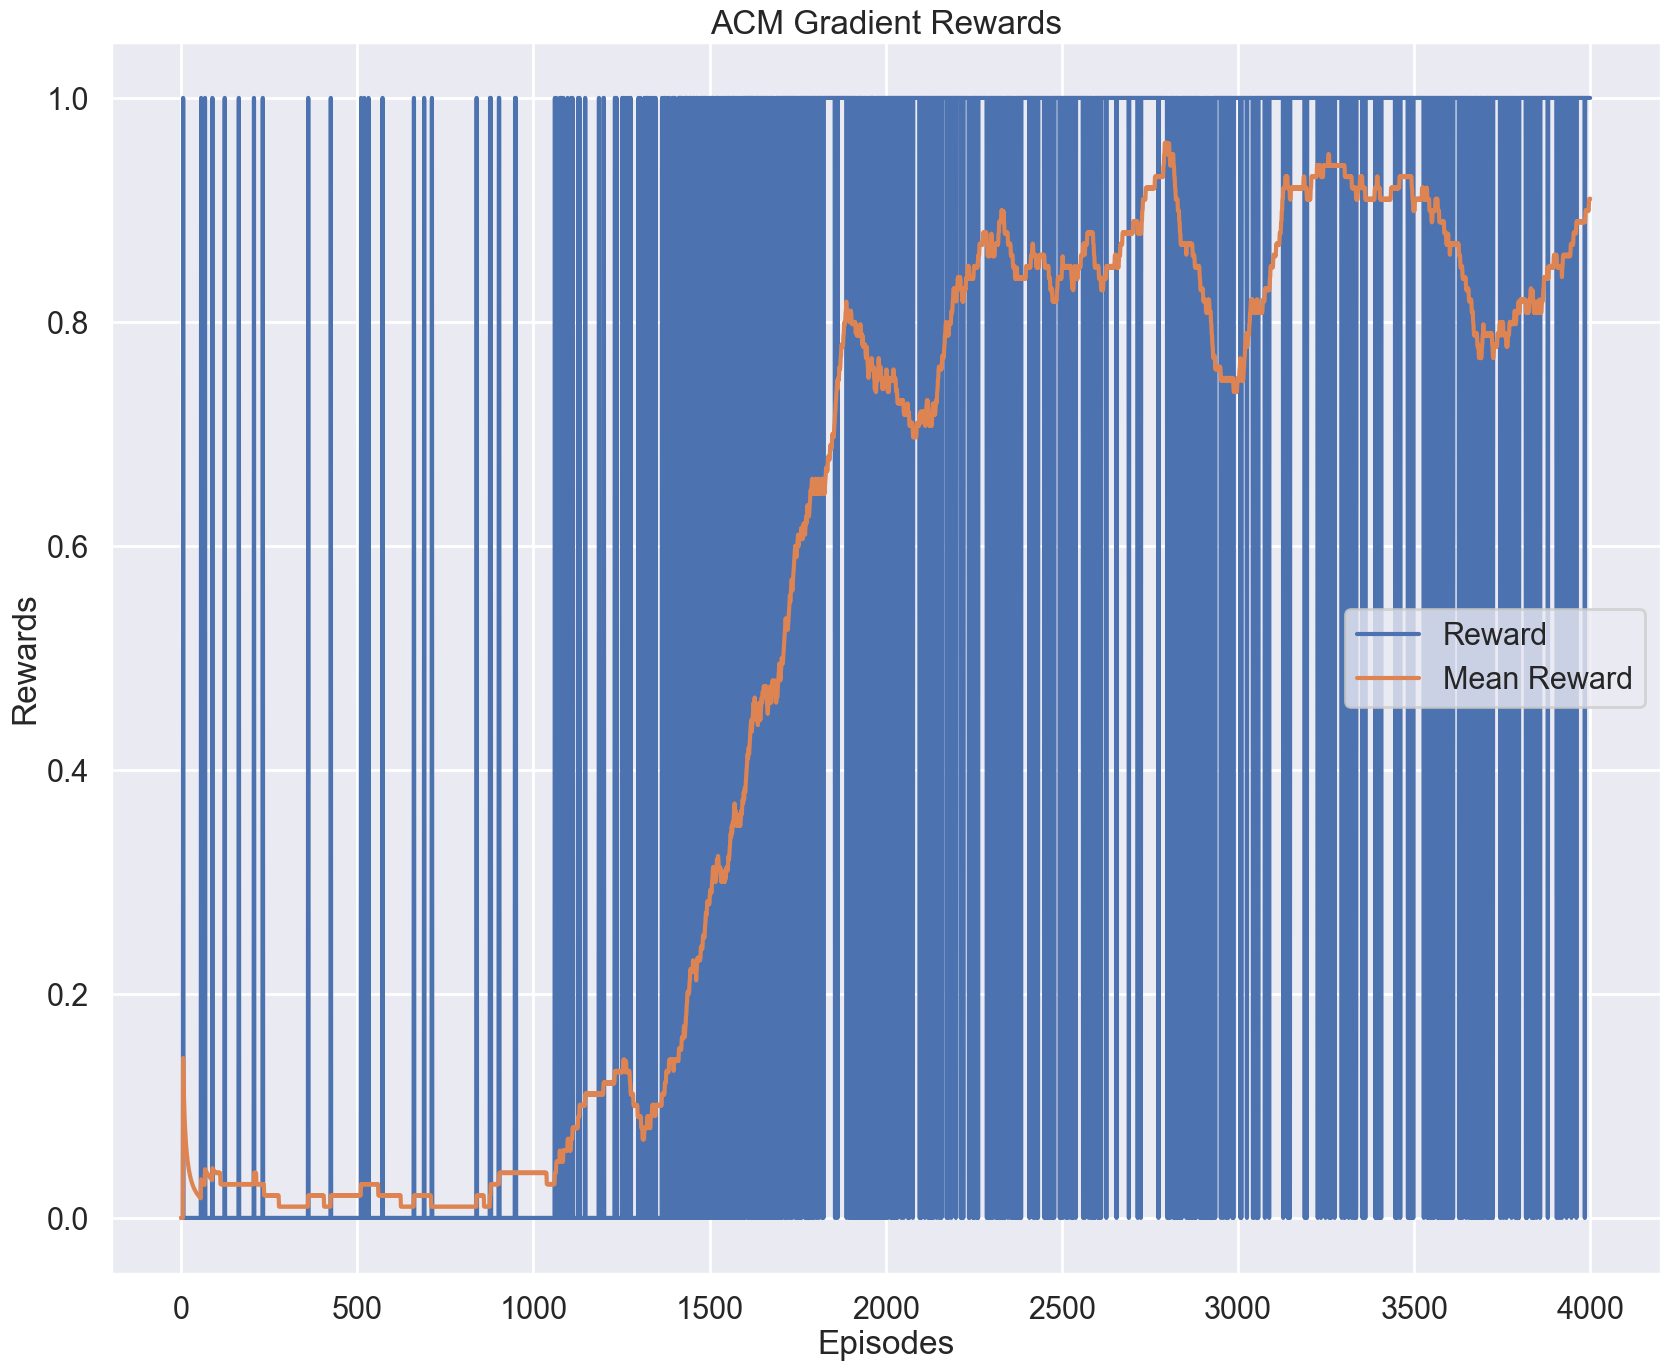

In [40]:
if __name__ == "__main__":
    RL_hyperparams = {
        "number_of_experiments": 50,
        "num_episodes": 4000,
        "lr": 1e-4,
        "eps_start": 0.999,
        "eps_end": 0.01,
        "eps_decay": 0.999,
        "gamma": 0.999,
        "batch_size": 32,
        "learn_every": 4,
        "random_seed": 42,
    }

    main(RL_hyperparams=RL_hyperparams)